In [1]:
%matplotlib inline
# 魔法命令
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

•	true_w 是真实的权重向量，这里有两个元素，分别对应两个特征的系数，即线性关系中的斜率参数。
•	true_b 是真实的偏置（截距），即线性函数中的常数项。
整体的线性关系可以写作：
y = 2x_1 - 3.4x_2 + 4.2

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])
print(features.shape)
print(labels.shape)


features: tensor([-1.1005, -0.3998]) 
label: tensor([3.3583])
torch.Size([1000, 2])
torch.Size([1000, 1])


set_figsize() 通常用于 在 Jupyter Notebook 或 Python 脚本中绘图时，调整图表的大小，使其更易于观察。
num_examples: 数据集的样本数
true_w: 线性回归的真实权重
true_b: 线性回归的真实偏置
•	features：形状 (1000, 2)，即 1000 行 2 列，代表 1000 个样本，每个样本有两个特征 (x1, x2)。
•	labels：形状 (1000, 1)，代表每个样本对应的 y 值。

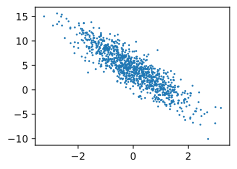

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

•	这里用 len(features) 获取数据集中样本的总数。假设 features 是一个形状为 (N, d) 的张量，则 num_examples 就是 N，即样本数量。
•	生成一个从 0 到 num_examples - 1 的整数列表，用来标识每个样本的索引。
•	使用 random.shuffle 对索引列表进行原地随机打乱，使得数据的顺序随机化。这样在每个 epoch 中，每个批次的数据顺序都是不同的，有助于提高模型训练的鲁棒性。


In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.4802,  0.3696],
        [ 0.2901, -2.2799],
        [-0.9069, -0.3172],
        [-0.4266, -1.5946],
        [-0.7037,  1.1501],
        [-0.2736,  0.5103],
        [-0.0757, -1.2425],
        [ 0.6969,  0.0252],
        [ 1.2480, -0.5712],
        [-0.8166,  1.4722]]) 
 tensor([[-0.0175],
        [12.5300],
        [ 3.4430],
        [ 8.7636],
        [-1.1110],
        [ 1.9251],
        [ 8.2853],
        [ 5.5222],
        [ 8.6464],
        [-2.4481]])


In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w.grad, b.grad)
w, b

None None


(tensor([[0.0028],
         [0.0050]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

优化算法

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():  # 用于禁止计算梯度，通常用于推理（inference）或者手动更新参数的场景
        for param in params:  # sgd 来更新参数w和b
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 梯度清零

开始训练

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [12]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        # print('w.grad:', w.grad)
        # print('b.grad:', b.grad)
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032939
epoch 2, loss 0.000120
epoch 3, loss 0.000049


In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0001, -0.0010], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
